# Net position change
along a single dimension.
$$
\Delta{x}=max(x_2,x_1)-min(x_2,x_1)
$$

$$
x_1\le\Vert\Delta{x}\Vert\le x_2
$$

In [62]:
def return_net_position_change(x1, x2):
    return max(x1,x2) - min(x1,x2)

print(return_net_position_change(3,5))
print(return_net_position_change(1,-2))

2
3


In [29]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
sample_rate, wav = scipy.io.wavfile.read("713034__womb_affliction__fem-vocals-added-to-composingatnight-sound-693766.wav")
print(wav.shape[0], "samples")
print(wav.shape[1], "channels")
length = wav.shape[0] / sample_rate
print(length, "seconds")

In [31]:
wav.dtype

dtype('int16')

In [32]:
wav

array([[0, 0],
       [0, 0],
       [0, 1],
       ...,
       [3, 5],
       [2, 4],
       [3, 6]], dtype=int16)

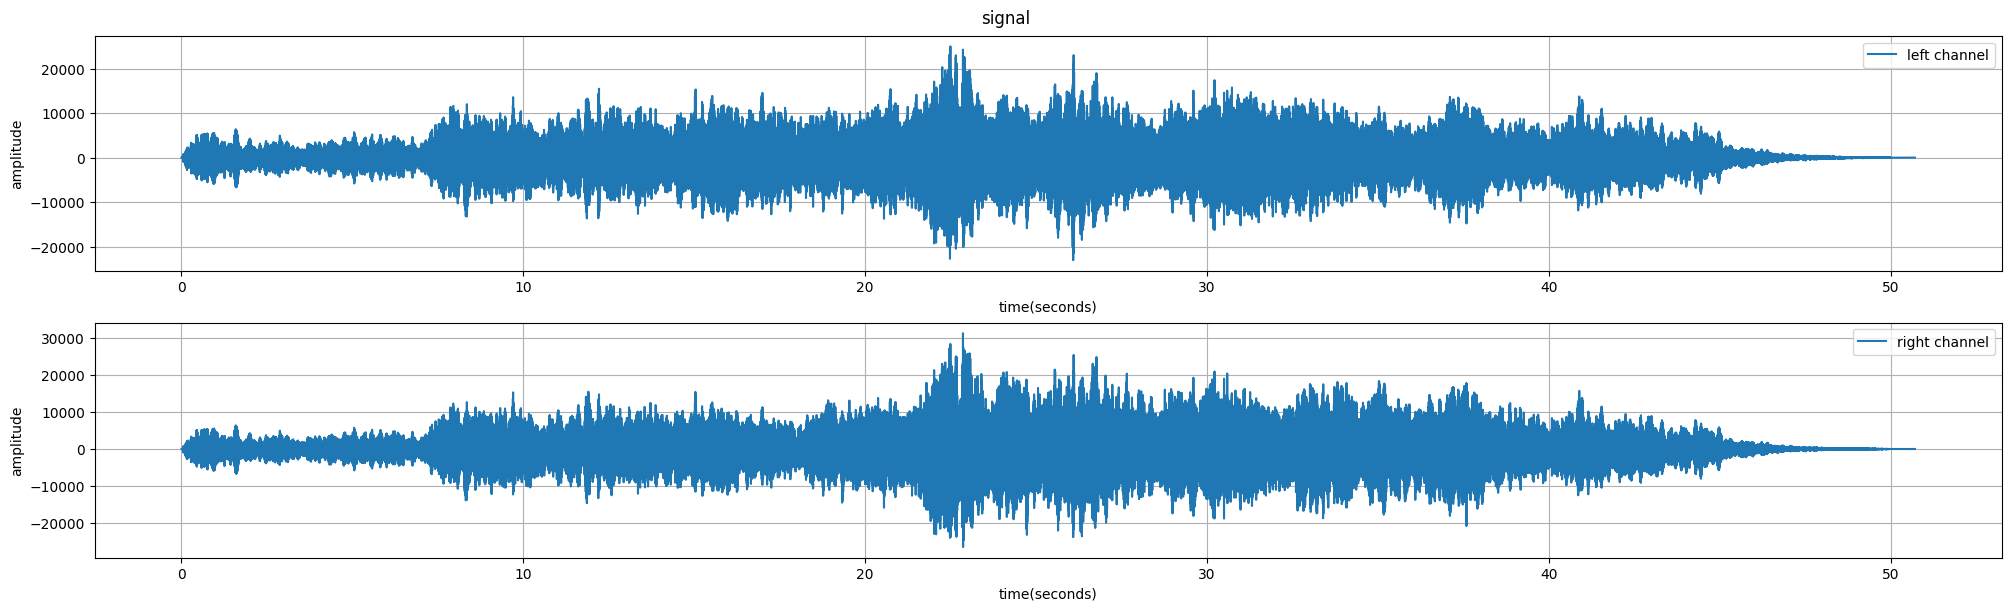

In [95]:
x = np.linspace(0., length, wav.shape[0])
fig, axs = plt.subplots(ncols=1, nrows=2, layout="constrained", figsize=[20,6])
axs[0].plot(x, wav[:, 0], label="left channel")
axs[1].plot(x, wav[:, 1], label="right channel")
axs[0].grid(); axs[1].grid()
fig.suptitle("signal")
axs[0].set_xlabel("time(seconds)")
axs[1].set_xlabel("time(seconds)")
axs[0].set_ylabel("amplitude")
axs[1].set_ylabel("amplitude")
axs[0].legend()
axs[1].legend()
plt.show()

In [84]:
fourier_xform = np.fft.fft(wav)
n = wav.size
timestep = 0.1
freqs = np.fft.fftfreq(n, d=timestep)

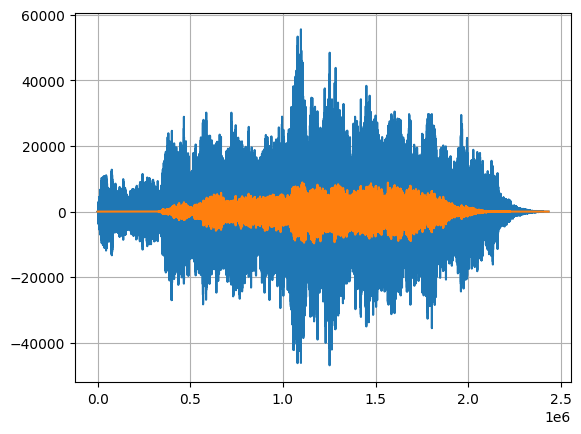

In [103]:
plt.plot(fourier_xform.real)
plt.grid()

In [105]:
print(fourier_xform.shape)
print(wav.shape)

(2433768, 2)
(2433768, 2)


# SDR parameters

http://websdr.ewi.utwente.nl:8901/

15100.00 khz usb # chinese radio

23.4 khz cw # supposed submarine data comms

7020.52 khz am 9khz filter # amateur morse code

In [141]:
# ws://websdr.ewi.utwente.nl:8901/~~stream
# GET /~~param?mute=0
# GET /~~param?squelch=0
# GET /~~param?autonotch=0
# GET /~~param?f=198.000&band=0&lo=-4.5&hi=4.5&mode=1&name=

ws = create_connection("ws://websdr.ewi.utwente.nl:8901/~~stream")
ws.send("GET /~~param?mute=0")
ws.send("GET /~~param?squelch=0")
ws.send("GET /~~param?autonotch=0")
ws.send("GET /~~param?f=198.000&band=0&lo=-4.5&hi=4.5&mode=1&name=")
start = time.time()
stop = time.time()
while stop-start < 2:
    message = ws.recv()
    with open("audio_data.bin", "ab") as f:
        f.write(message)
    stop = time.time()
ws.close()

# Convert binary data into wav

In [1]:
from pydub import AudioSegment

with open("audio_data.bin", "rb") as f:
    audio_data = f.read()
audio_segment = AudioSegment(data=audio_data, sample_width=2, 
frame_rate=48000, channels=1)

# Play or save the decoded audio segment
audio_segment.export("decoded_audio.wav", format="wav")

FileNotFoundError: [Errno 2] No such file or directory: 'audio_data.bin'

In [2]:
import audiofile
from IPython.display import Audio
signal, sampling_rate = audiofile.read("websdr_recording_start_2024-07-08T13_14_14Z_22.1kHz.wav")
Audio(signal, rate=sampling_rate)

In [1]:
# import rel

# import websocket

# addr = "wss://api.gemini.com/v1/marketdata/%s"

# def write_msg(m):
#     with open("events.txt", "a") as f:
#         f.write(m+"\n")

# if __name__ == "__main__":
#     for symbol in ["BTCUSD", "ETHUSD", "ETHBTC"]:
#         ws = websocket.WebSocketApp(addr % (symbol,), on_message=lambda w, m: write_msg(m))
#         ws.run_forever(dispatcher=rel)
#     rel.signal(2, rel.abort)  # Keyboard Interrupt
#     rel.dispatch()

# Streaming structure data

In [1]:
import rel
import websocket

addr = "wss://api.gemini.com/v1/marketdata/%s"

if __name__ == "__main__":
    with open("events2.txt", "a") as f:
        for symbol in ["BTCUSD", "ETHUSD", "ETHBTC"]:
            ws = websocket.WebSocketApp(addr % (symbol,), on_message=lambda w, m: f.write(m+"\n"))
            ws.run_forever(dispatcher=rel)
        rel.signal(2, rel.abort)  # Keyboard Interrupt
        rel.dispatch()

In [3]:
import json
# open the event stream
with open("events2.txt", "r") as f:
    t = f.read()
all_events = []
for event in t.splitlines():
    event = json.loads(event)
    # print(event['eventId'])
    all_events.append(event)

In [4]:
import pandas as pd
df = pd.json_normalize(all_events)

In [5]:
df.columns

Index(['eventId', 'events', 'socket_sequence', 'type', 'timestamp',
       'timestampms'],
      dtype='object')

In [6]:
df.dtypes

eventId              int64
events              object
socket_sequence      int64
type                object
timestamp          float64
timestampms        float64
dtype: object

In [7]:
df.head()

,eventId,events,socket_sequence,type,timestamp,timestampms
0,1713630225990134,"[{'delta': '0.01948', 'price': '56484.08', 're...",0,update,NaN,NaN
1,1713630225990238,"[{'delta': '-1.0', 'price': '56524.73', 'reaso...",1,update,1.720464e+09,1.720464e+12
2,1713630225989549,"[{'delta': '0.0061', 'price': '0.05303', 'reas...",0,update,NaN,NaN
3,1713630225990239,"[{'delta': '-1.0', 'price': '56467.59', 'reaso...",2,update,1.720464e+09,1.720464e+12
4,1713630225990240,"[{'delta': '1.0', 'price': '56524.49', 'reason...",3,update,1.720464e+09,1.720464e+12


In [8]:
df.size

44598

In [9]:
len(df)

7433

In [10]:
# locate the ith row, and slice out
# all but the events column
pd.DataFrame(df.loc[0]).T[['eventId','socket_sequence','type','timestamp','timestampms']]

,eventId,socket_sequence,type,timestamp,timestampms
0,1713630225990134,0,update,NaN,NaN


In [11]:
# normalize the 'events' column
pd.json_normalize(df.loc[0]['events'])

,delta,price,reason,remaining,side,type
0,0.01948,56484.08,initial,0.01948,bid,change
1,0.1753,56480.64,initial,0.1753,bid,change
2,0.0177,56475.43,initial,0.0177,bid,change
3,1.75303,56469.55,initial,1.75303,bid,change
4,1.0,56467.59,initial,1.0,bid,change
...,...,...,...,...,...,...
6137,0.00886498,5000000.0,initial,0.00886498,ask,change
6138,0.2,5200000.0,initial,0.2,ask,change
6139,2.30364753,10000000.0,initial,2.30364753,ask,change
6140,0.00025279,100000000.0,initial,0.00025279,ask,change


In [9]:
import requests
import numpy as np
import pandas as pd
from io import StringIO

In [19]:
res = requests.get('https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/sick2014/SICK_train.txt')
data = pd.read_csv(StringIO(res.text), sep='\t')
data.head()

,pair_ID,sentence_A,sentence_B,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL


In [46]:
sentences = data['sentence_A'].tolist()
s_B = data['sentence_B'].tolist()
sentences.extend(s_B)

In [68]:
urls = [
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.train.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/MSRpar.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2012/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2013/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/OnWN.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2014/images.test.tsv',
    'https://raw.githubusercontent.com/brmson/dataset-sts/master/data/sts/semeval-sts/2015/images.test.tsv'
]
# response = requests.get(url)

for url in urls:
    res = requests.get(url)
    # extract to dataframe
    data = pd.read_csv(StringIO(res.text), sep='\t', header=None, on_bad_lines='skip')
    # add to columns 1 and 2 to sentences list
    sentences.extend(data[1].tolist())
    sentences.extend(data[2].tolist())

In [69]:
len(sentences)

20470

In [73]:
# remove duplicates and NaN
sentences = [word for word in list(set(sentences)) if type(word) is str]

In [76]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
model = SentenceTransformer('bert-base-nli-mean-tokens')
# create sentence embeddings
sentence_embeddings = model.encode(sentences)
sentence_embeddings.shape

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(14504, 768)

In [77]:
sentence_embeddings[0]

array([ 1.5832458 ,  0.07289829,  0.42311117, -0.05511888,  0.15127611,
        1.4193296 ,  1.8074234 ,  0.2739248 , -0.9965586 ,  0.30348247,
       -0.4965462 ,  0.20038462,  0.44499522,  0.7924705 ,  0.85405016,
        0.47867477, -0.42903033, -0.32426956, -0.062412  ,  0.10837434,
       -0.42153972,  0.41811252,  0.7214017 , -1.0224595 , -0.799599  ,
       -0.5864471 ,  0.36565417,  0.00447842, -0.971547  ,  0.52024835,
        0.22810516,  0.8125046 ,  0.50532126, -0.06282511,  1.5704396 ,
       -0.24211589,  0.10679732, -0.25586468,  0.01272906, -1.2914047 ,
        0.17385978, -0.02961305,  0.61059165,  0.6199995 ,  0.3248188 ,
        0.16270673,  0.7243085 ,  0.22246203,  0.21073654, -0.03846996,
        0.05289815, -0.873375  ,  1.9725542 ,  0.8090654 , -0.4204896 ,
        0.18051456, -0.20120394, -0.8719759 ,  0.33250496,  0.08693942,
        0.36829484, -0.19964814, -0.18669605, -0.1306113 , -0.48772126,
       -0.16509047,  0.6369895 , -0.01098687, -0.17897221, -0.89